# Examples: Learning Capabilities

This notebook provides some examples of how to use Time Blender to learn model parameters from observable data.

In [1]:
from time_blender.random_events import *
from time_blender.deterministic_events import *
from time_blender.coordination_events import *

from time_blender.core import *
from time_blender.models import SimpleModels, ClassicModels, BankingModels, EconomicModels, EcologyModels

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

import urllib.request 
import zipfile
import copy
import os.path

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]

Let us define a helper function to generate and plot the models.

In [3]:
def generate_and_plot(models, start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 6, 30), 
                      n=1, freq='D'):
    
    data = generate(models, start_date, end_date, n=n, freq=freq)

    # plot
    for i in range(0, n):
        data[i].plot()
        plt.show()
    

## Banking behavior

We'll try to learn some banking behavior here.

### Data

Let us use the user data from a Czech bank from a competition. Details can be found [here](https://sorry.vse.cz/~berka/challenge/pkdd1999/chall.htm), [here](https://webpages.uncc.edu/mirsad/itcs6265/group1/index.html) and [here](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions). We are interested in the evolution of each user's bank account.

Download data locally if we have not already done so.

In [4]:
if not os.path.isfile('../data/pkdd99_discovery_challenge_banking_dataset.zip'):
    urllib.request.urlretrieve('http://data.paulosalem.com/datasets/pkdd99_discovery_challenge_banking_dataset.zip', 
                               '../data/pkdd99_discovery_challenge_banking_dataset.zip')

In [5]:
with zipfile.ZipFile('../data/pkdd99_discovery_challenge_banking_dataset.zip') as myzip:
    with myzip.open('pkdd99_discovery_challenge_banking_dataset/data/trans.csv') as f:
        df_trans = pd.read_csv(f, parse_dates=['date'], infer_datetime_format=True)

df_trans.head()

/home/salem/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


Let us now isolate each individual.



In [6]:
account_ids = df_trans['account_id'].unique()
users_transacions = {} # account id -> dataframe with transactions

In [7]:
for acc_id in account_ids:
    users_transacions[acc_id] = df_trans[df_trans['account_id'] == acc_id]

We need a function to plot the user's balance.



In [8]:
def user_balance_series(acc_id, users_transactions=users_transacions):
    df_u = users_transacions[acc_id]
    s_balance = df_u.groupby(df_u['date'])['balance'].mean()
    
    # fill the gaps, if any
    new_idx = pd.date_range(s_balance.index[0], s_balance.index[-1], freq=s_balance.index.freq)
    s_balance = s_balance.reindex(new_idx, method='ffill')
    
    return s_balance

In [9]:
def plot_user(acc_id, users_transactions=users_transacions, same_figure=False):
    s_balance = user_balance_series(acc_id, users_transactions)
    s_balance.plot(title=f'Acc. ID = {acc_id}, #events = {len(s_balance)}')
    if not same_figure:
        plt.show()

Let us pick a few random users to plot.



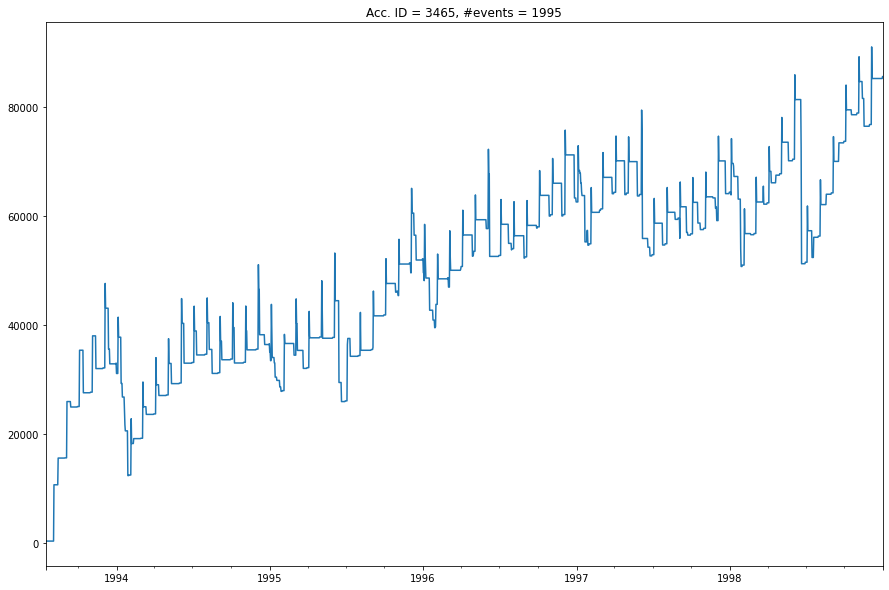

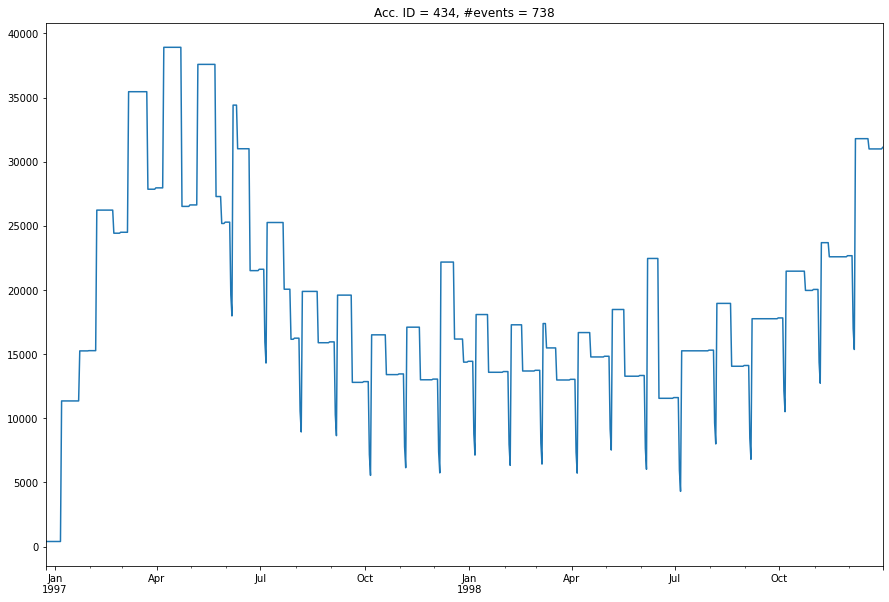

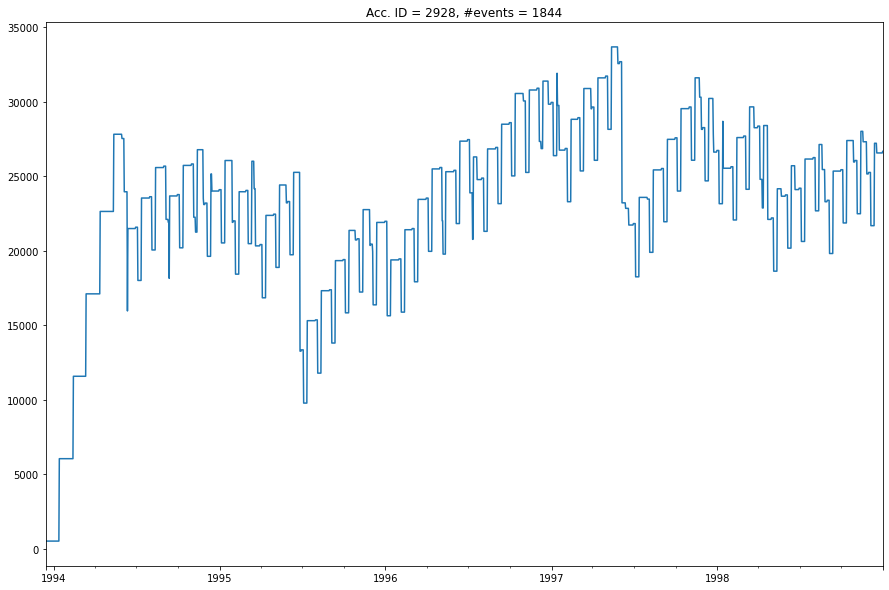

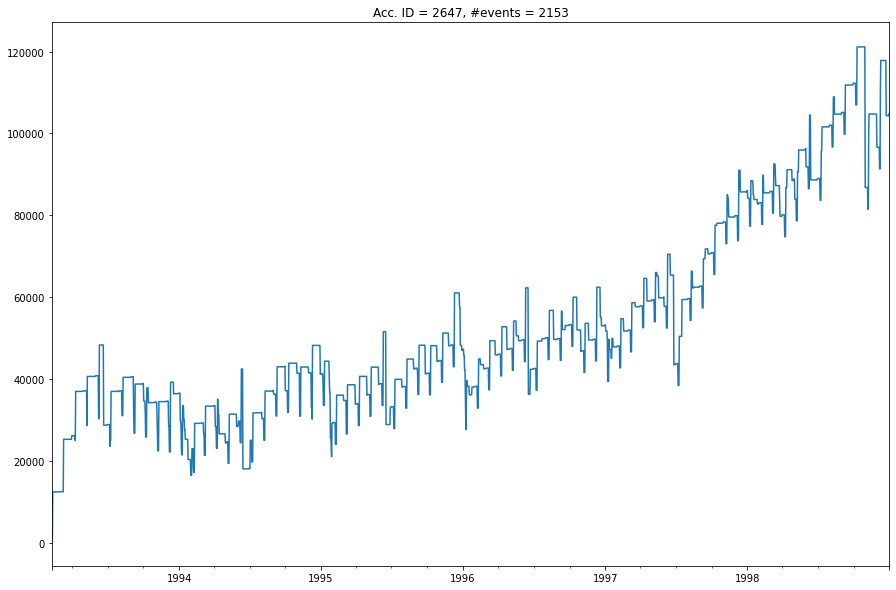

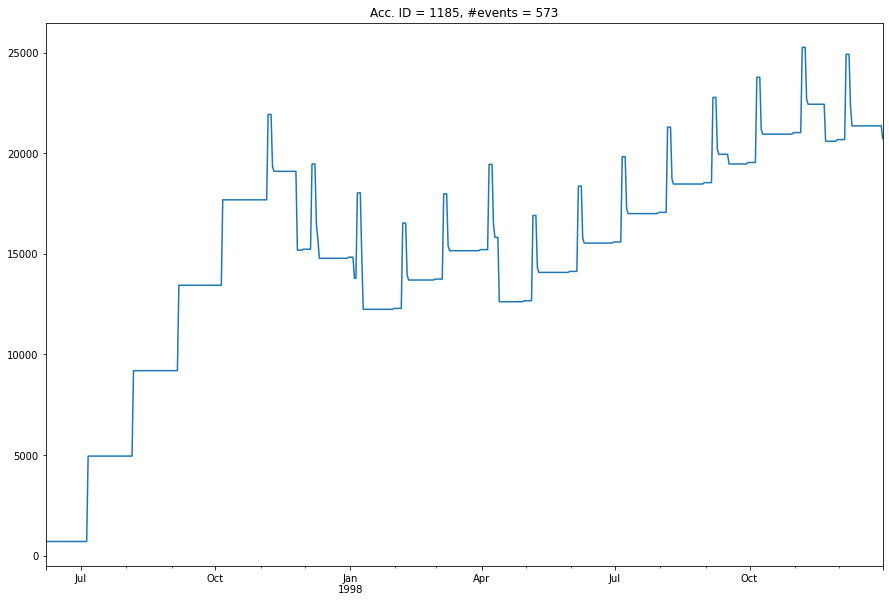

In [10]:
selected_account_ids = random.sample(list(account_ids), k=5)

for acc_id in selected_account_ids:
    plot_user(acc_id)

### TimeBlender Model

Now we can define a TimeBlender to learn from these data.

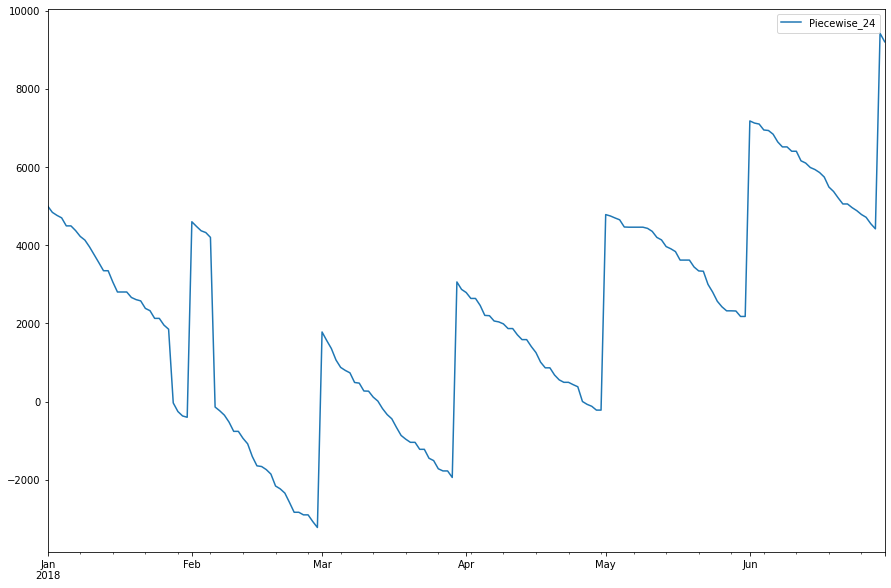

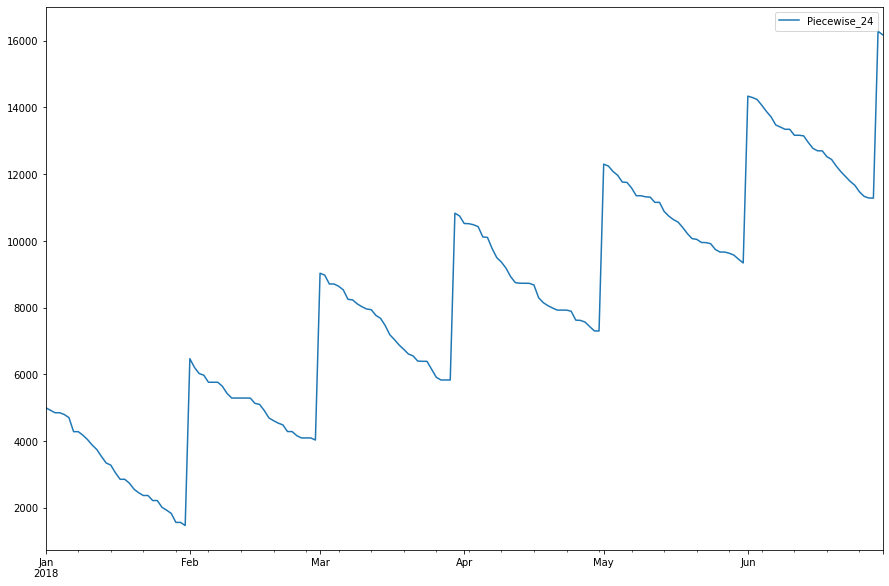

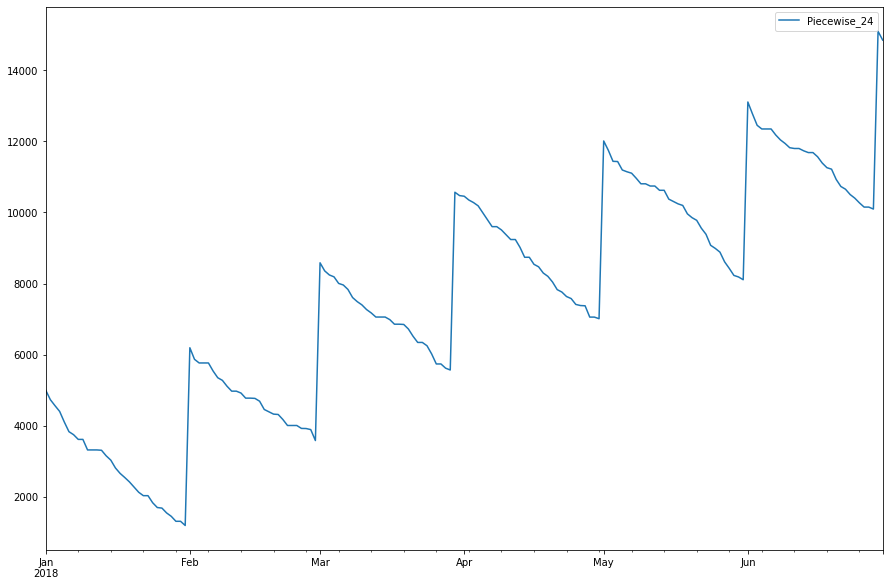

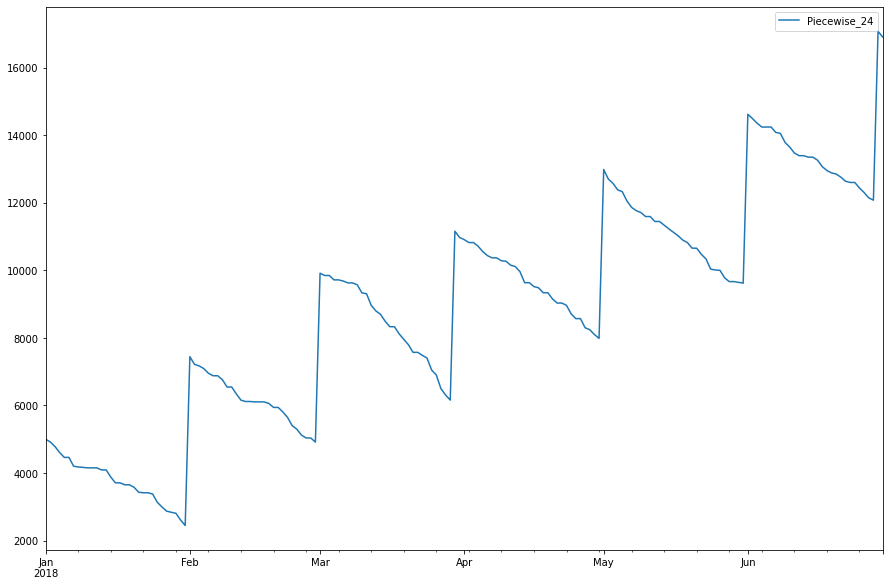

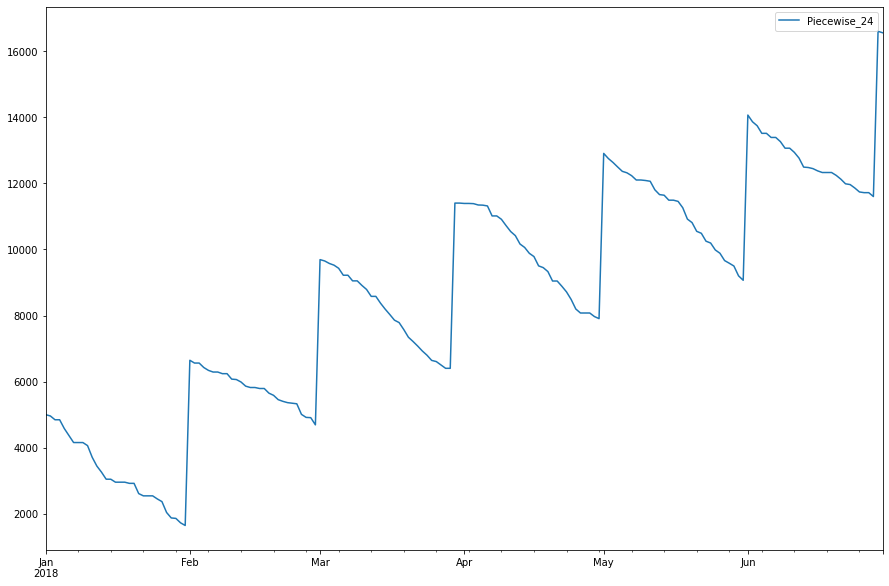

In [11]:
banking_model_1 = BankingModels.salary_earner(salary=ConstantEvent(5000.0, 
                                                                 require_lower_bound=0, 
                                                                 require_upper_bound=30000),
                                            expense_mean=ConstantEvent(100.0, 
                                                               require_lower_bound=0, 
                                                               require_upper_bound=1000),
                                            expense_sd=ConstantEvent(100.0, 
                                                                     require_lower_bound=0, 
                                                                     require_upper_bound=30000))

banking_model_2 = banking_model_1.clone()
banking_model_3 = banking_model_1.clone()

t_separator_1 = NormalEvent(ConstantEvent(60.0, 
                                          require_lower_bound=0, 
                                          require_upper_bound=600), 
                            ConstantEvent(20.0, 
                                          require_lower_bound=0, 
                                          require_upper_bound=600))

t_separator_2 = t_separator_1.clone()

pw = Piecewise([banking_model_1, banking_model_2, banking_model_3],  
               t_separators=[t_separator_1, t_separator_2])


model = pw
generate_and_plot(model, n=5)

Let's select some traces to elarn from.

In [12]:
observed_traces = [user_balance_series(acc_id, users_transactions=users_transacions).values 
                   for acc_id in selected_account_ids]
#observed_traces

And actually learn them. 

In [13]:
model.generalize_from_observations(observed_traces, 
                                   max_optimization_evals=300, 
                                   n_simulations=5,
                                   error_strategy = 'best_trace')

# error_strategy = 'all_traces'
# error_strategy = 'best_trace'

LambdaEvent_5
ClipEvent_4
NormalEvent_3
ConstantEvent_1
ConstantEvent_2
ClipEvent_4_min_value
LambdaEvent_5_clone-11
ClipEvent_4_clone-10
NormalEvent_3_clone-8
ConstantEvent_1_clone-6
ConstantEvent_2_clone-7
ClipEvent_4_min_value_clone-9
LambdaEvent_5_clone-17
ClipEvent_4_clone-16
NormalEvent_3_clone-14
ConstantEvent_1_clone-12
ConstantEvent_2_clone-13
ClipEvent_4_min_value_clone-15
NormalEvent_20
ConstantEvent_18
ConstantEvent_19
NormalEvent_20_clone-23
ConstantEvent_18_clone-21
ConstantEvent_19_clone-22
{'ConstantEvent_1': <hyperopt.pyll.base.Apply object at 0x7ff970dea4e0>, 'ConstantEvent_2': <hyperopt.pyll.base.Apply object at 0x7ff970dea3c8>, 'ClipEvent_4_min_value': <hyperopt.pyll.base.Apply object at 0x7ff9760cc7f0>, 'ConstantEvent_1_clone-6': <hyperopt.pyll.base.Apply object at 0x7ff9760cc320>, 'ConstantEvent_2_clone-7': <hyperopt.pyll.base.Apply object at 0x7ff9760cc3c8>, 'ClipEvent_4_min_value_clone-9': <hyperopt.pyll.base.Apply object at 0x7ff970df3f60>, 'ConstantEvent_1_clo

Here's the result.

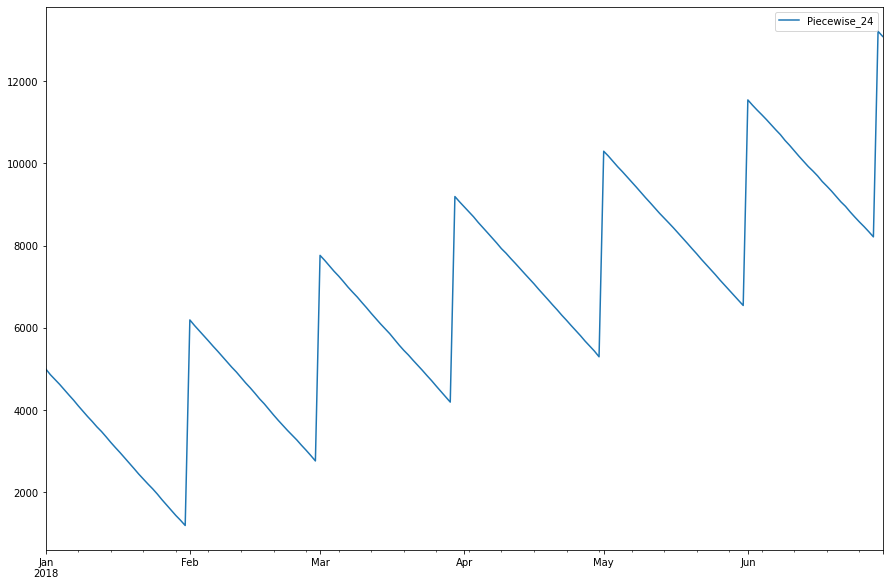

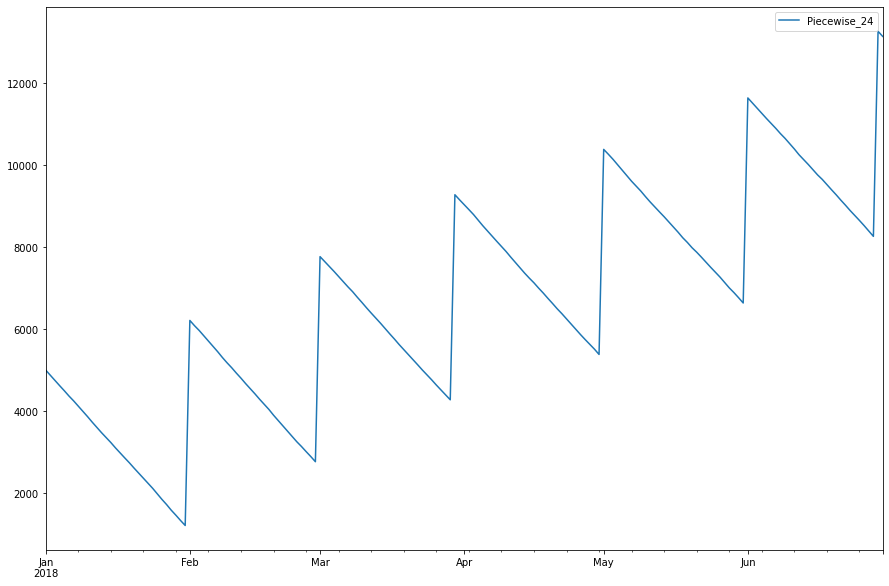

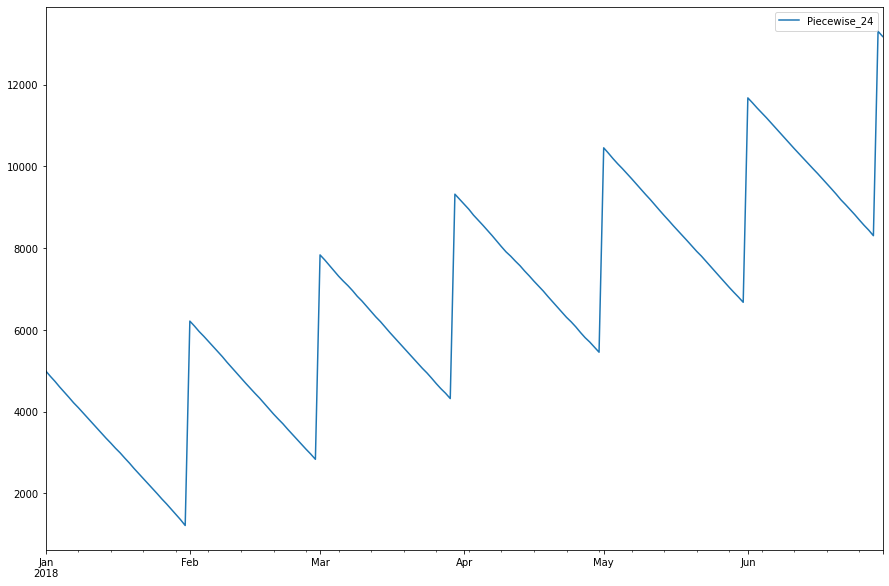

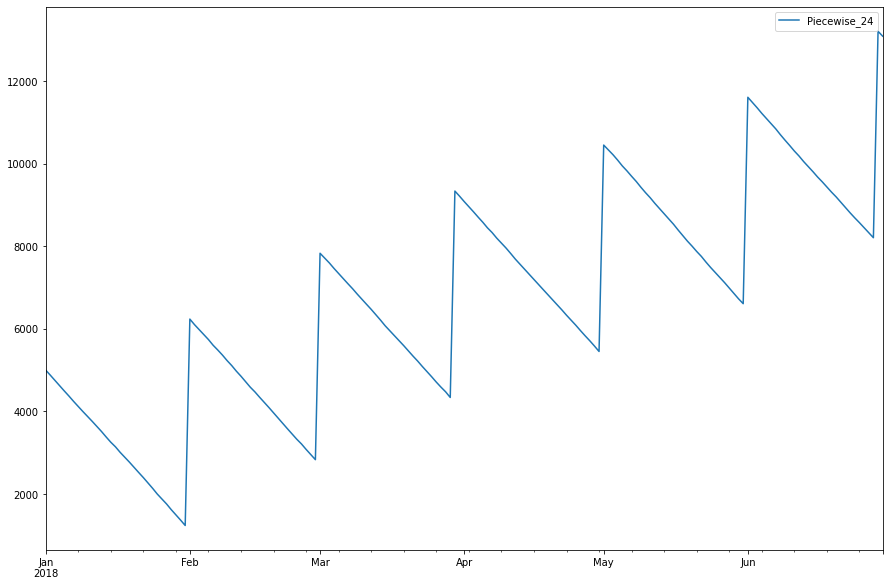

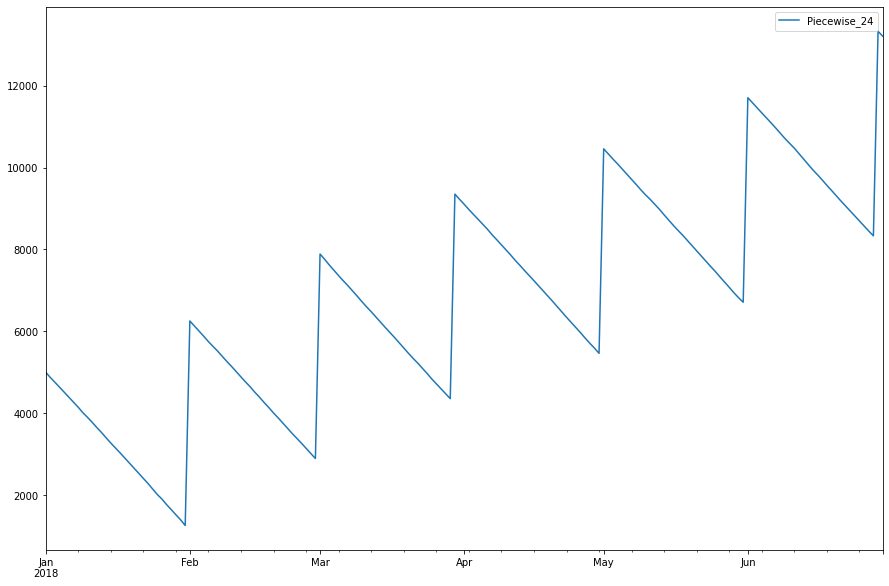

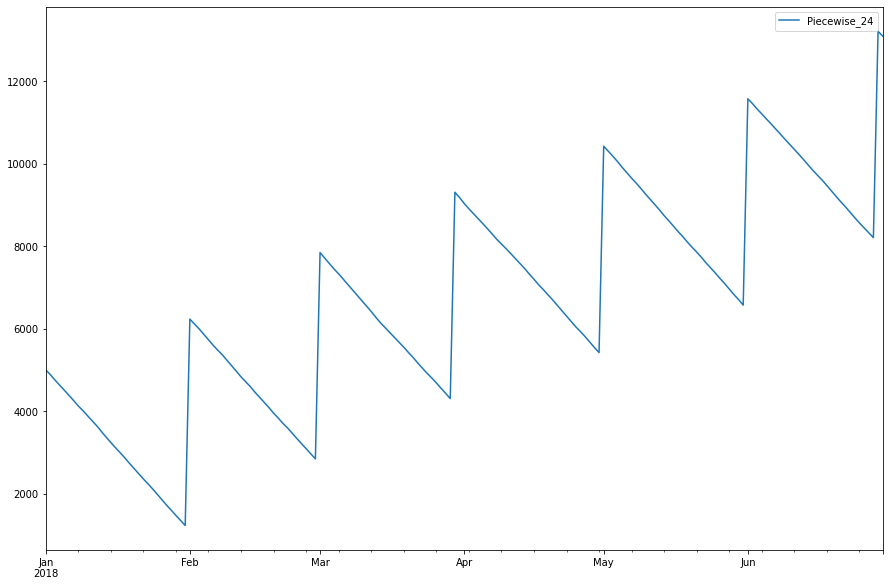

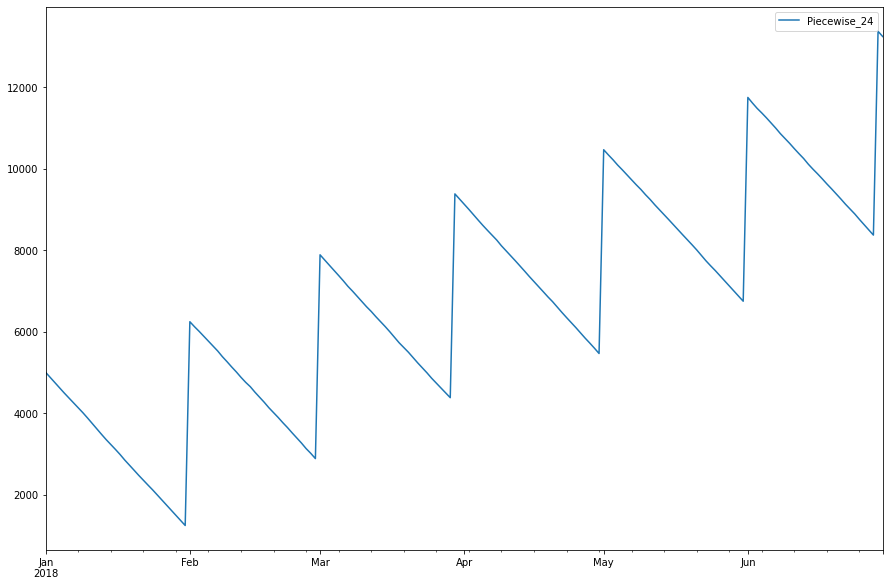

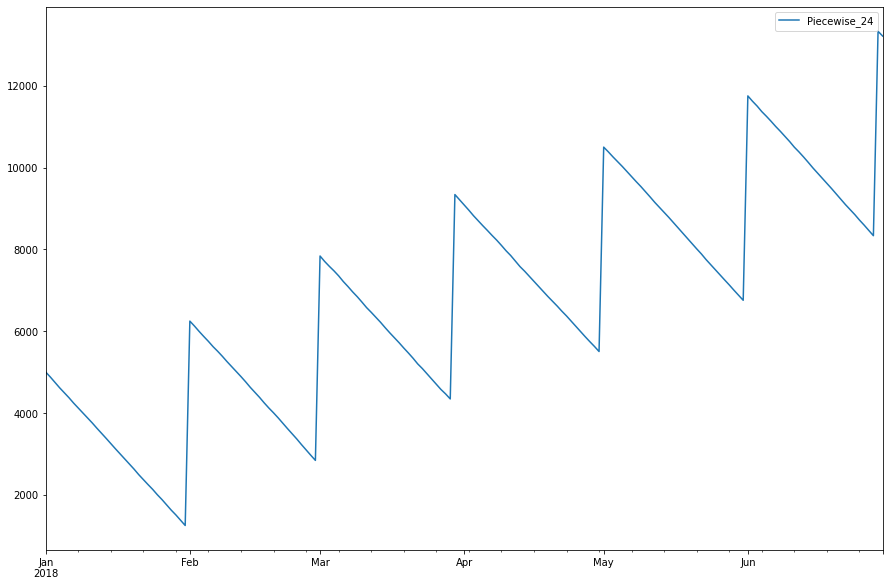

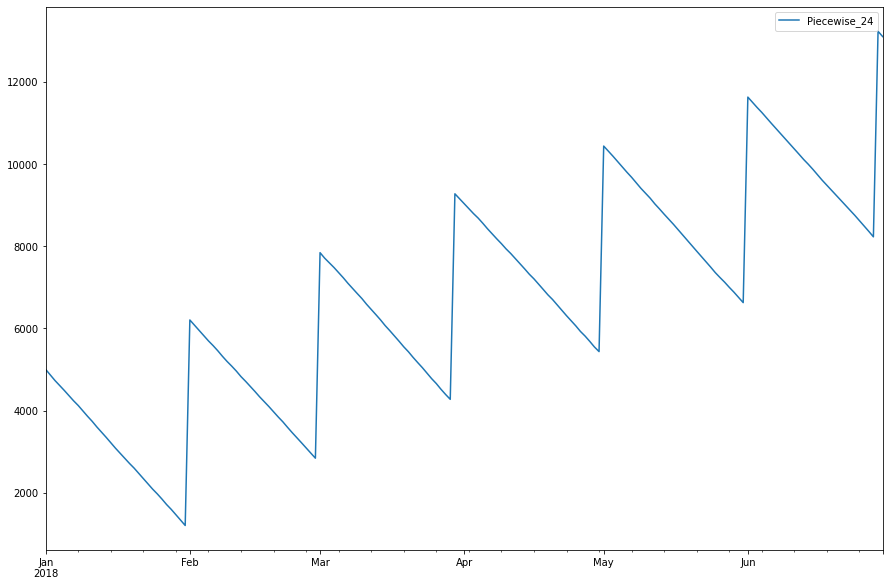

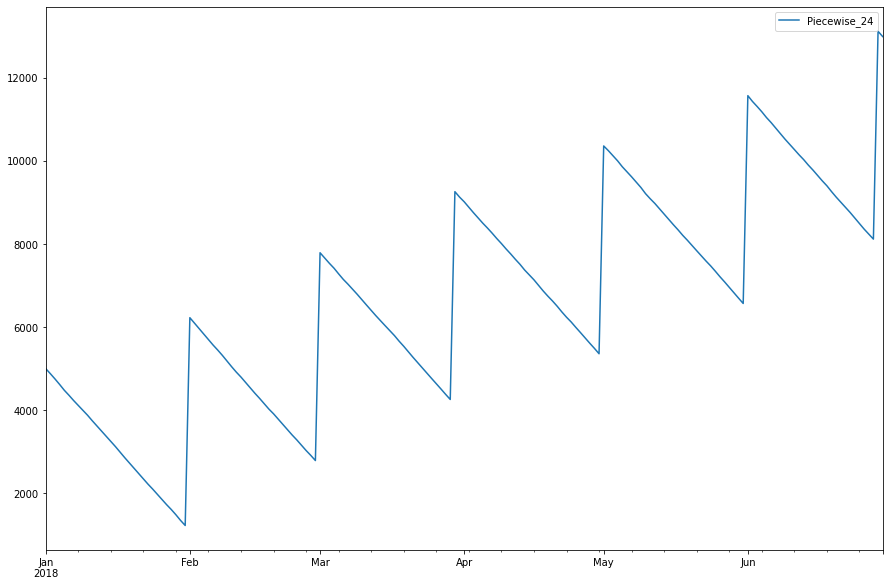

In [14]:
generate_and_plot(model, n=10, start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 6, 30), 
                  freq='D')